## Workflow:

1. Download today's data from G.h to gdrive folder, either through API or bulk download.

2. Calculate completeness metrics globally. Optional extra: calculate per-record quality scores, and plot for each country/source, compare across map.

Figure 1a: Completeness heatmap 
Figure 1b: Chloropleth map of record quality

3. Given list of countries of interest (start with LatAm), calculate time deltas as extra columns.

4. Given time deltas, plot delay distributions. Plot using simple density plot, also infer using pystan/rStan.

Figure 2a: Chloropleth map of time deltas, with delays colour coded (larger the time delay, darker the colour). Could also include bi-variate chloropleth map.
Figure 2b: Delay distribution plots (compare line plots for different countries).

OPTIONAL extra: Overlay maps against G.h data fields such as outcome, to see whether time delays or data  quality correlates with outcomes

### Data Availability

- Colombia, Argentina, Mexico and Brazil all have dates for onsetSymptoms and Death.

- Colombia has no hospitalisation dates. Mexico has hospitalisation dates for a subset of cases, but for this subset date of hospitalisation = date of confirmation

- Argentina and Brazil have dates for onsetSymptoms, hospitalisation and outcome.

In [106]:
import pandas as pd
import numpy as np
import os
import io
import hashlib
import requests
import json
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
import pickle
# import stan
import datetime
import matplotlib.dates as mdates
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas.tools import sjoin


In [107]:
def get_time_deltas(linelist,timedeltas_dict):
    '''
    Get the time interval between two events. First takes subset of cases which have genuine values for the two fields of interest.
    
    Input: df; the name of the two columns in chronological order (first event, second event); desired name of the resulting time_delta col
    '''

    for delta in timedeltas_dict.keys():
        field1,field2 = timedeltas_dict[delta]
        linelist[delta] = (pd.to_datetime(linelist[field2],format='%Y-%m-%d') - pd.to_datetime(linelist[field1],format='%Y-%m-%d')).dt.days

    return linelist

def aggregate_cases_to_admin2(country,country_shapefile_path):
    '''
    Take a shapefile and a country, get the G.h linelist associated with this country, then aggregate (mean) 
    all points in this country to admin2 resolution. Return an aggregated geopandas geodataframe ready for plotting.
    
    Need to provide the correct shapefile to load. It needs to contain a polygon geometry column, and a column called ADM2_PCODE, 
    containing codes for each adm2 region.
    '''
    linelist = country_df_dict[country]
    country_shapefile = gpd.read_file(country_shapefile_path)
    try:
        country_shapefile = country_shapefile.to_crs('EPSG:4326')
    except:
        pass
    geometry = [Point(xy) for xy in zip(linelist['location.geometry.longitude'].astype(float),linelist['location.geometry.latitude'].astype(float))]
    geo_df = gpd.GeoDataFrame(linelist,
                         crs="EPSG:4326",
                         geometry=geometry)
    joined = gpd.sjoin(geo_df,country_shapefile)
    linelist_adm2_aggregated = joined.groupby('ADM2_PCODE').mean()
    country_shapefile_with_variables = country_shapefile.merge(linelist_adm2_aggregated,left_on='ADM2_PCODE',right_index=True)

    return joined,country_shapefile_with_variables



def aggregate_cases_to_admin1(country,country_shapefile_path):
    '''
    Take a shapefile and a country, get the G.h linelist associated with this country, then aggregate (mean) 
    all points in this country to admin2 resolution. Return an aggregated geopandas geodataframe ready for plotting.
    
    Need to provide the correct shapefile to load. It needs to contain a polygon geometry column, and a column called ADM2_PCODE, 
    containing codes for each adm2 region.
    '''
    linelist = country_df_dict[country]
    country_shapefile = gpd.read_file(country_shapefile_path)
    try:
        country_shapefile = country_shapefile.to_crs('EPSG:4326')
    except:
        pass
    geometry = [Point(xy) for xy in zip(linelist['location.geometry.longitude'].astype(float),linelist['location.geometry.latitude'].astype(float))]
    geo_df = gpd.GeoDataFrame(linelist,
                         crs="EPSG:4326",
                         geometry=geometry)
    joined = gpd.sjoin(geo_df,country_shapefile)
    linelist_adm_aggregated = joined.groupby('ADM1_PCODE').mean()
    country_shapefile_with_variables = country_shapefile.merge(linelist_adm_aggregated,left_on='ADM1_PCODE',right_index=True)

    return joined,country_shapefile_with_variables

In [108]:
# raw_data_dir = '/Users/felix/Documents/DPhil/global_health/covid_data/gh_2021-11-29/country/'
raw_data_dir = '/Users/felix/Documents/DPhil/global_health/covid_data/gh_2021-12-23/country/'

save_dir = '/Users/felix/Documents/DPhil/global_health/delay_distributions/processed_data/'

### Per record completeness + quality scores

- Calculate how many fields are not empty for each case, as a proxy for quality.

- What additional metrics could a quality/richness score include, other than case completeness?

- Could try different weightings for different end-user activities: eg case quality for demographic comparisons, case quality for estimating delay distributions (need as many dates as possible), case quality for geo resolution.

- How to extend across all countries? Data and plotting constraints

- May need to aggregate by region when plotting, otherwise too much information to plot/store if on an individual case level

In [109]:
target_countries = ['colombia','brazil','mexico','argentina']
# target_countries = ['colombia','mexico']
# target_countries = ['argentina']
# target_countries = ['brazil']

country_df_dict = {}
for country in target_countries:
    country_df_dict[country] = pd.read_csv(f'{raw_data_dir}{country}.csv.gz')

/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (17,19,66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,9,10,12,14,16,17,18,19,20,21,22,32,38,41,42,49,50,66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,20,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/felix/opt/anaconda3/envs/gh_maps2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (66) have mixed types.Speci

### Add completeness scores

In [110]:
for i,country in enumerate(target_countries):
    linelist = country_df_dict[country]
    linelist['completeness_score'] = pd.notnull(linelist[list(linelist.columns)[7:]]).sum(axis=1)

### Calculate Time Deltas

1. Make list of target countries and inspect completeness ==> which deltas can be calculated

2. Define dict of time deltas to calculate

3. For each country in target list, pass dict containing time deltas to function

### Get all outcome events as separate cols

In [111]:
for i,country in enumerate(target_countries):
    linelist = country_df_dict[country]
    print(f'Outcome fields for {country} are \n')
    for outcome in [u for u in linelist['events.outcome.value'].unique() if pd.notnull(u)]:
        print(outcome)
        if outcome in ['hospitalAdmission','icuAdmission']: 
            linelist[f"events.{outcome}.date"] = linelist.loc[linelist['events.outcome.value']==outcome]['events.outcome.date']
        else:
            linelist[f"Date_of_{outcome}"] = linelist.loc[linelist['events.outcome.value']==outcome]['events.outcome.date']


Outcome fields for colombia are 

Recovered
Death
Outcome fields for brazil are 

Recovered
Death
Outcome fields for mexico are 

Death
Outcome fields for argentina are 

Recovered
hospitalAdmission
Death
icuAdmission


### Check co-occurrence of event dates

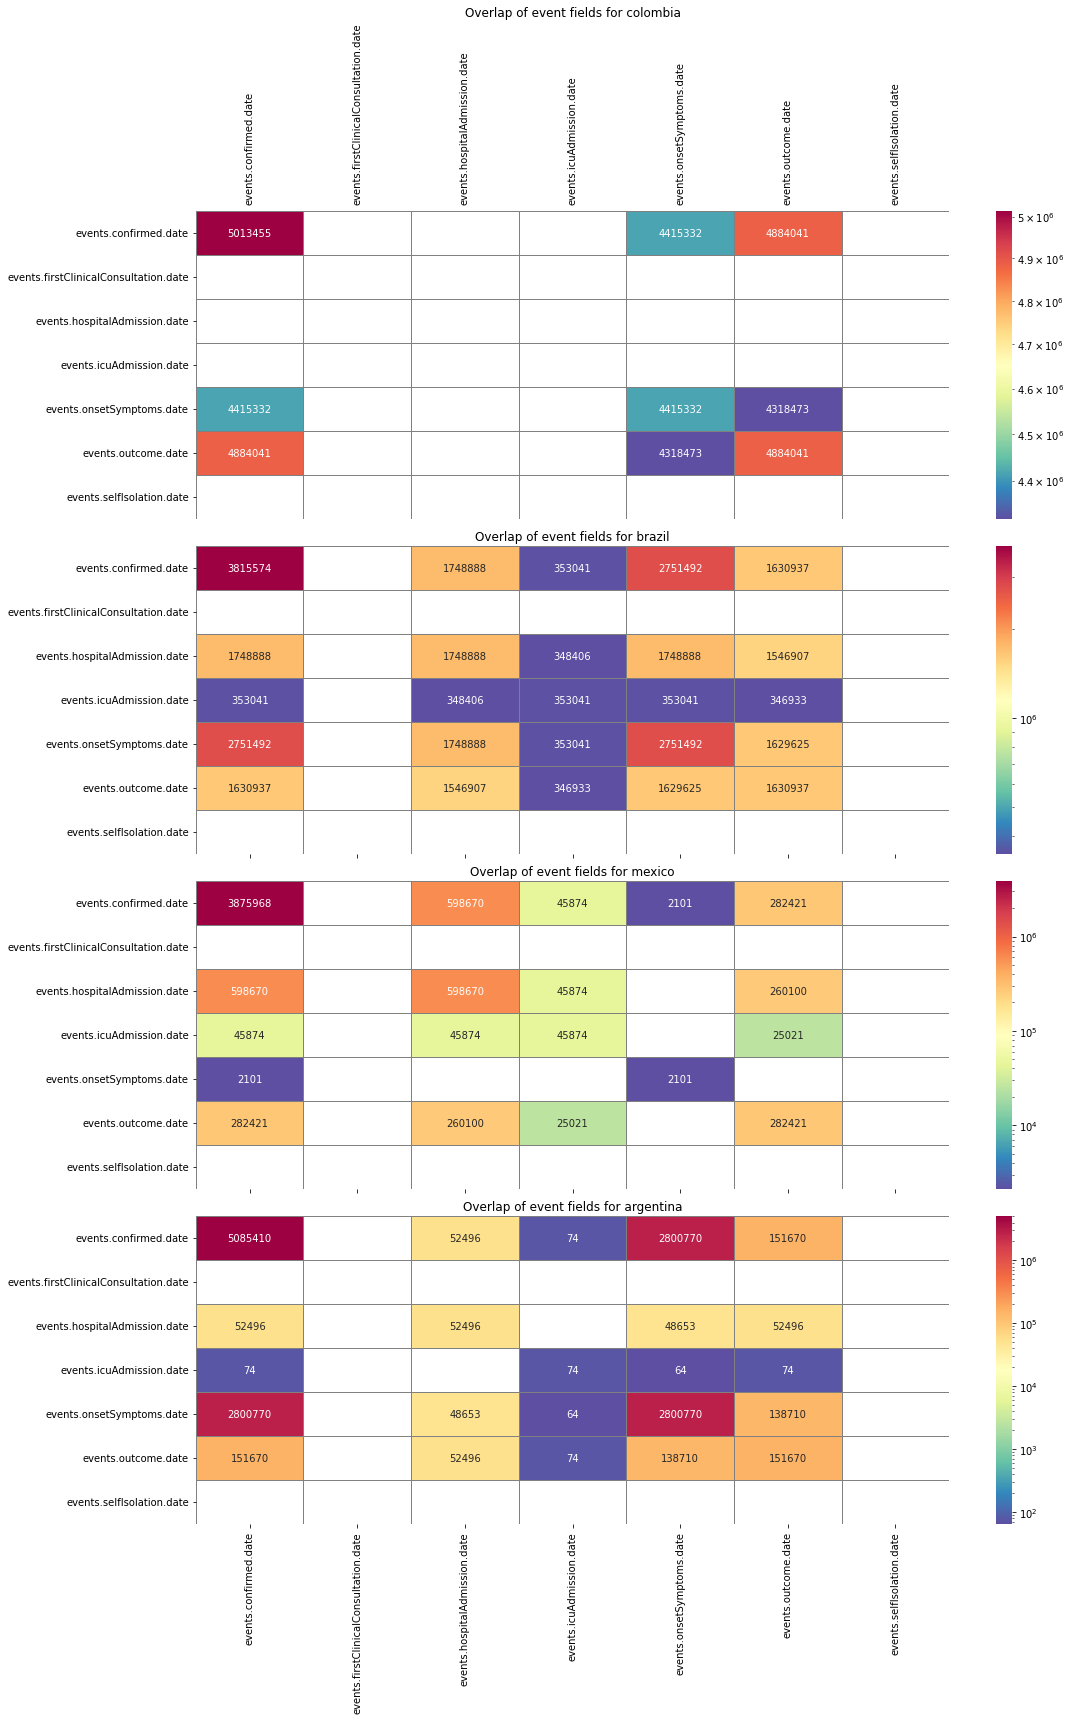

In [112]:
from matplotlib.colors import LogNorm, Normalize
event_cols = [u for u in linelist.columns if 'event' in u]
event_date_cols = [u for u in event_cols if 'date' in u]

fig,axes = plt.subplots(4,1,figsize=(16,24),sharex=True)
for i,country in enumerate(target_countries):
    ax = axes[i]
    if i ==0:
        ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
    df = pd.notnull(country_df_dict[country].loc[:,event_date_cols])
    df = df.astype(int)
    co_occ_matrix = df.T.dot(df)

    sns.heatmap(co_occ_matrix,ax=ax,linewidth=0.5,linecolor='grey',cmap='Spectral_r',annot=True,fmt='d',robust=True,norm=LogNorm())
    # ax.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True,rotation=30)
    ax.set_title(f'Overlap of event fields for {country}')

fig.tight_layout()

### Inspecting key events for individual countries

- Mexico only has events.onsetSymptoms.date for a small subset of cases between

/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/1785978436.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)
/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/1785978436.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)
/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/1785978436.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)
/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/1785978436.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since M

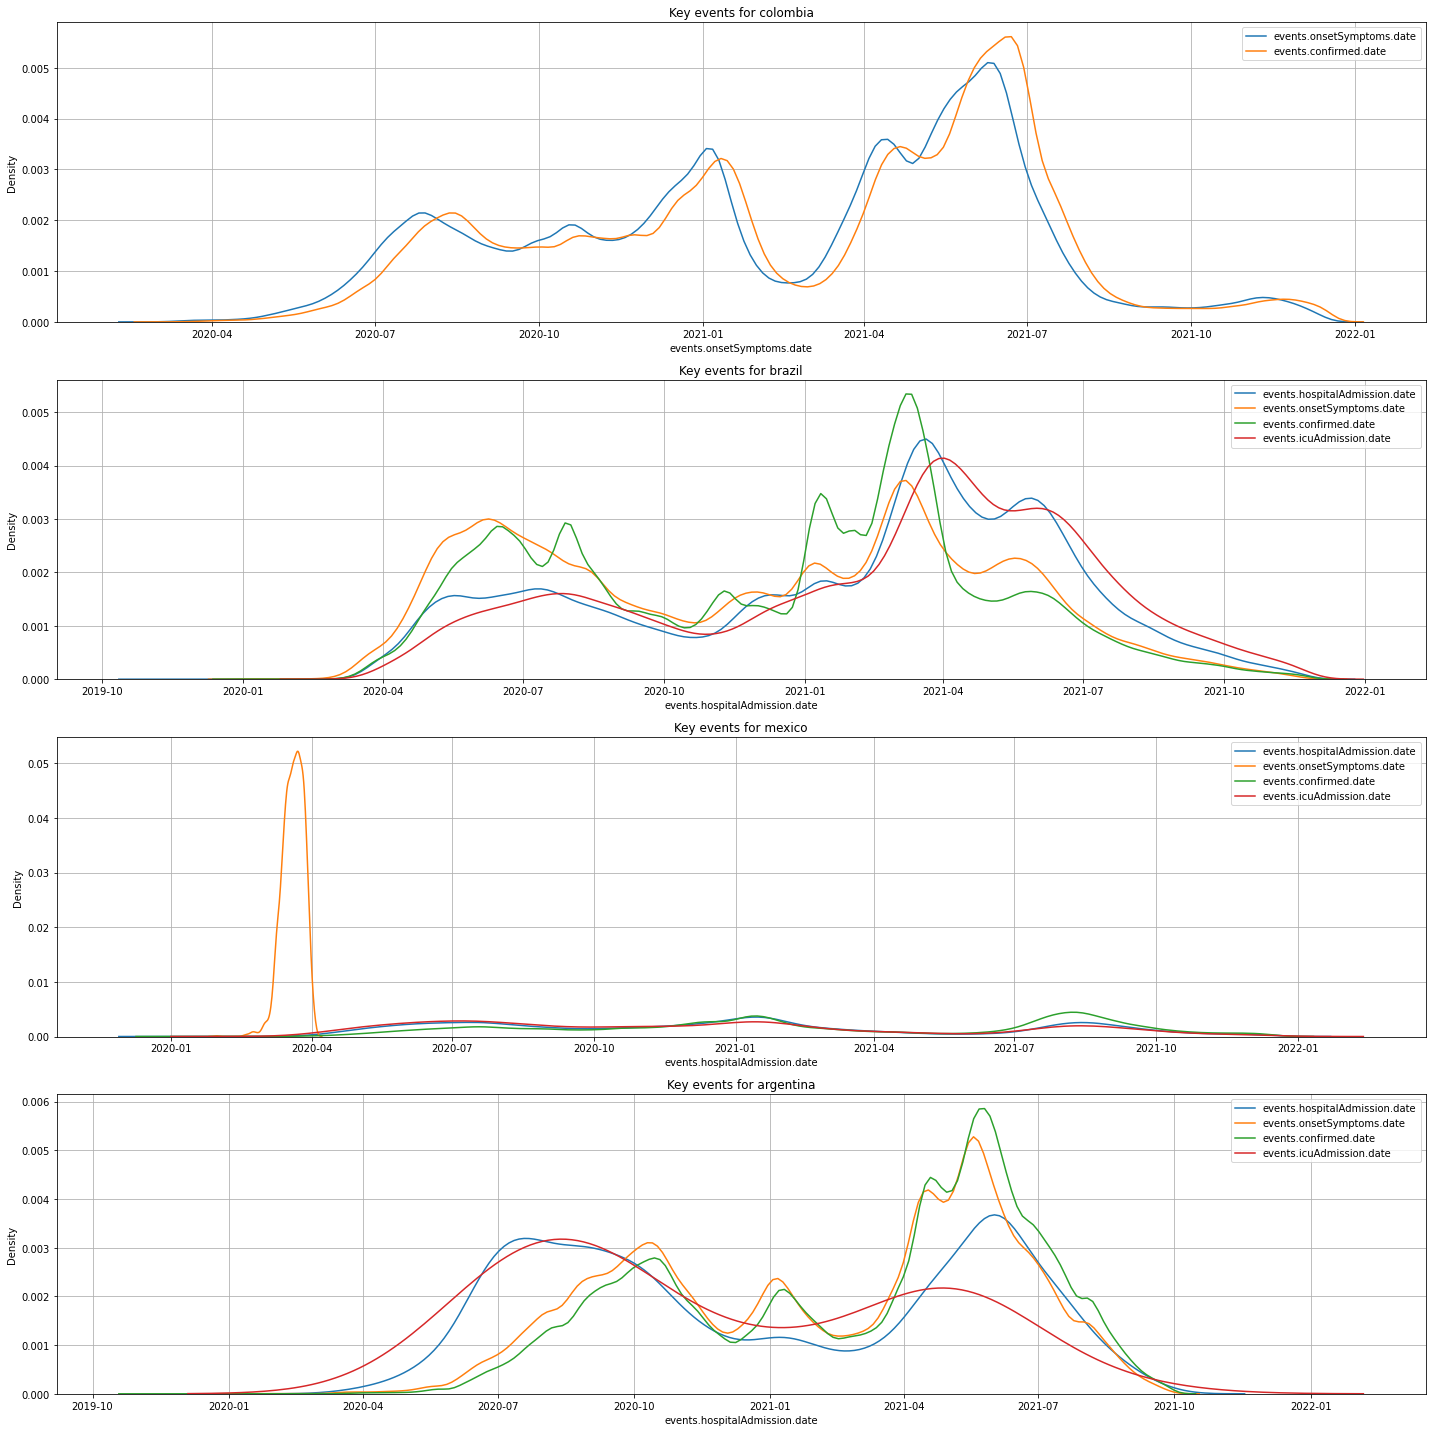

In [131]:
fig,axes = plt.subplots(4,1,figsize=(20,20))

for k,country in enumerate(target_countries):
    ax=axes[k]
    linelist = country_df_dict[country]
    relevant_cols = ['events.hospitalAdmission.date','events.onsetSymptoms.date','events.confirmed.date','events.icuAdmission.date']
    for col in relevant_cols:
        sns.kdeplot(pd.to_datetime(linelist[col]),label=col,ax=ax)

    ax.legend()
    ax.set_title(f'Key events for {country}')
    ax.grid(b=True)
# sns.kdeplot(pd.to_datetime(linelist['events.hospitalAdmission.date']),label=col)
# sns.kdeplot(pd.to_datetime(linelist['events.confirmed.date']))
fig.tight_layout()

#### All cases with hospital admissions in Mexico have date confirmed the same day

- Therefore not a useful metric


/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/943281272.py:4: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


Text(0, 0.5, 'Mexico hospital admission date')

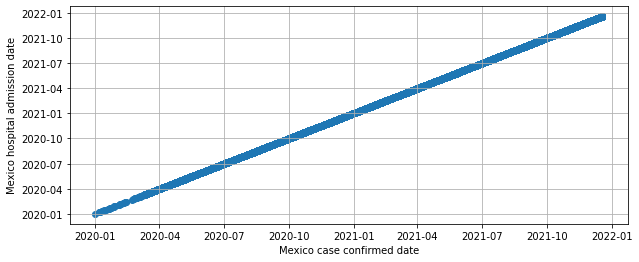

In [130]:
fig,ax = plt.subplots(figsize=(10,4))
linelist = country_df_dict['mexico']
ax.scatter(pd.to_datetime(linelist['events.confirmed.date']),pd.to_datetime(linelist['events.hospitalAdmission.date']))
ax.grid(b=True)
ax.set_xlabel('Mexico case confirmed date')
ax.set_ylabel('Mexico hospital admission date')

### Get time deltas for each country

Convert data to format:

case | epi_param 


1. symptom onset --> notification

2. symptom onset --> hospitalisation

3. symptom onset --> outcome

4. hospitalisation --> outcome


- Need to caveat by completeness of each field, and how many cases have both fields required to calculate delay

#### Store all time deltas to calculate in a dict, where:

- Name of each key is the desired timedelta column name
- The value of each key is a list, containing the two fields/epi_events of interest, stored in chronological order.

In [115]:
timedeltas_to_calculate = {} # list dates in chronological order, so first date first
timedeltas_to_calculate['delta_symptom_onset_to_confirmed'] = ['events.onsetSymptoms.date','events.confirmed.date']
timedeltas_to_calculate['delta_symptom_onset_to_hospitalisation'] = ['events.onsetSymptoms.date','events.hospitalAdmission.date']
timedeltas_to_calculate['delta_symptom_onset_to_icu_admission'] = ['events.onsetSymptoms.date','events.icuAdmission.date']
# timedeltas_to_calculate['delta_symptom_onset_to_hospitalisation'] = ['events.onsetSymptoms.date','Date_of_hospitalAdmission']
timedeltas_to_calculate['delta_symptom_onset_to_death'] = ['events.onsetSymptoms.date','Date_of_Death']
timedeltas_to_calculate['delta_confirmation_to_hospitalisation'] = ['events.confirmed.date','events.hospitalAdmission.date']
timedeltas_to_calculate['delta_confirmation_to_death'] = ['events.confirmed.date','Date_of_Death']

# timedeltas_to_calculate['symptom_onset_to_death'] = ['events.onsetSymptoms.date','Date_of_Recovered']
# timedeltas_to_calculate['delta_hospitalisation_to_death'] = ['events.hospitalAdmission.date','events.hospitalAdmission.date']

### Get timedeltas and add each as column

In [116]:
remove_negative_deltas = False
remove_threshold_deltas = True

for i,country in enumerate(target_countries):
    print(f"Getting timedeltas for {country} \n")
    country_df_dict[country] = get_time_deltas(country_df_dict[country],timedeltas_to_calculate)
    linelist = country_df_dict[country]
    
    # if remove_negative_deltas:
    #     for delta in timedeltas_to_calculate.keys():
    #         linelist[delta] = linelist[delta].clip(lower=-5)



        

Getting timedeltas for colombia 

Getting timedeltas for brazil 

Getting timedeltas for mexico 

Getting timedeltas for argentina 



#### Plot time deltas for each country - country omitted if absent

/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/1533648257.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axis.grid(b=True)
/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/1533648257.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axis.grid(b=True)
/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/1533648257.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axis.grid(b=True)
/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/1533648257.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' s

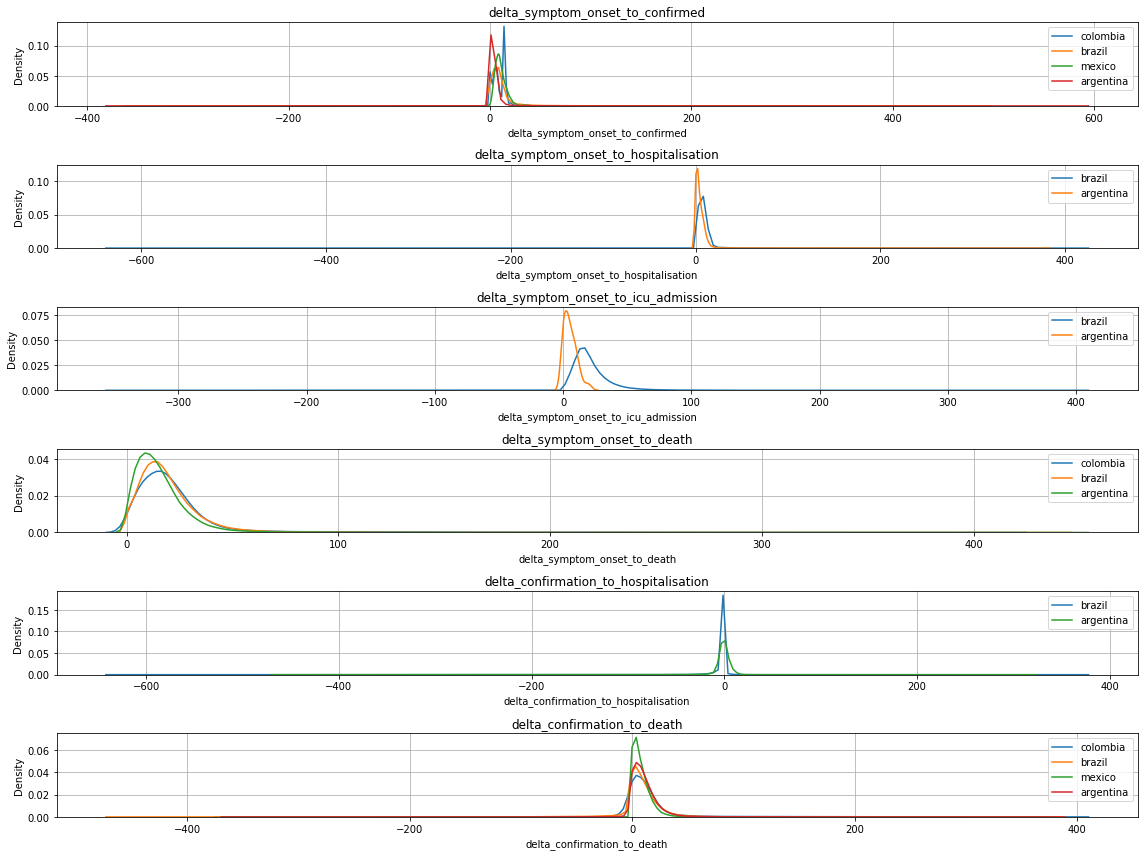

In [132]:
fig,ax = plt.subplots(len(timedeltas_to_calculate.keys()),figsize=(16,12))
    
for i,key in enumerate(timedeltas_to_calculate.keys()):
    axis = ax[i]
    axis.set_title(key)
    for country in target_countries:
        sns.kdeplot(country_df_dict[country][key],ax=axis,label=country)
        
    axis.legend()
    axis.grid(b=True)
    
fig.tight_layout()

### Make dict mapping country to admin shapefiles

In [118]:
country_adm_shapefile = {}

country_adm_shapefile['mexico'] = '/Users/felix/Documents/DPhil/global_health/geo_files/mex_admbnda_govmex_20210618_SHP/mex_admbnda_adm2_govmex_20210618.shp'
country_adm_shapefile['colombia'] = '/Users/felix/Documents/DPhil/global_health/geo_files/col-administrative-divisions-shapefiles/col_admbnda_adm2_mgn_20200416.shp'
country_adm_shapefile['brazil'] = '/Users/felix/Documents/DPhil/global_health/geo_files/bra_adm_ibge_2020_shp/bra_admbnda_adm2_ibge_2020.shp'
country_adm_shapefile['argentina'] = '/Users/felix/Documents/DPhil/global_health/geo_files/arg_adm_unhcr2017_shp/arg_admbnda_adm2_unhcr2017.shp'


### Save all linelists with coords mapped to admin2


In [119]:
# for country in country_df_dict.keys():
# # for country in ['brazil']:
#     print(f"working on {country}")
#     linelist_geocded,country_shapefile_with_delays = aggregate_cases_to_admin2(country,country_adm2_shapefile[country])
#     country_shapefile_with_delays.to_csv(save_dir + f"{country}_aggregatedtoadm2_delays.csv")
#     linelist_geocded.to_csv(save_dir + f"{country}_linelist_geocoded.csv")

### Save all linelists with coords mapped to admin1


In [120]:
country_shapefiles_with_delays_dict = {}
for country in country_df_dict.keys():
# for country in ['brazil']:
    print(f"working on {country}")
    linelist_geocded,country_shapefile_with_delays = aggregate_cases_to_admin1(country,country_adm_shapefile[country])
    country_shapefile_with_delays.to_csv(save_dir + f"{country}_aggregatedtoadm1_delays.csv")
    linelist_geocded.to_csv(save_dir + f"{country}_linelist_geocoded_adm1.csv")
    country_shapefiles_with_delays_dict[country] = country_shapefile_with_delays

working on colombia
working on brazil


/var/folders/w7/v_q95cy15l1_dbc5x1ltf1xw0000gn/T/ipykernel_20299/2596729321.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  joined = gpd.sjoin(geo_df,country_shapefile)


working on mexico
working on argentina


### Read in geocoded linelists

In [74]:
# for country in country_df_dict.keys():
# country = 'colombia'
# country_adm1_aggregated_dict = {}
# country_shapefile_dict = {}
# country_shapefiles_with_delays_dict = {}
# for country in [country]:
#     print(f"loading {country}")
    # country_adm1_aggregated_dict[country] = pd.read_csv(save_dir + f"{country}_aggregatedtoadm1_delays.csv")#.set_index('ADM1_PCODE')
    # country_shapefile_dict[country] = gpd.read_file(country_adm_shapefile[country])
    # country_shapefiles_with_delays[country] = country_shapefile_dict[country].merge(country_adm1_aggregated_dict[country],left_on='ADM1_PCODE',right_on='ADM1_PCODE')
    # linelist_geocded = pd.read_csv(save_dir + f"{country}_linelist_geocoded_adm1.csv")
    


loading colombia


### Plot delay distributions on maps

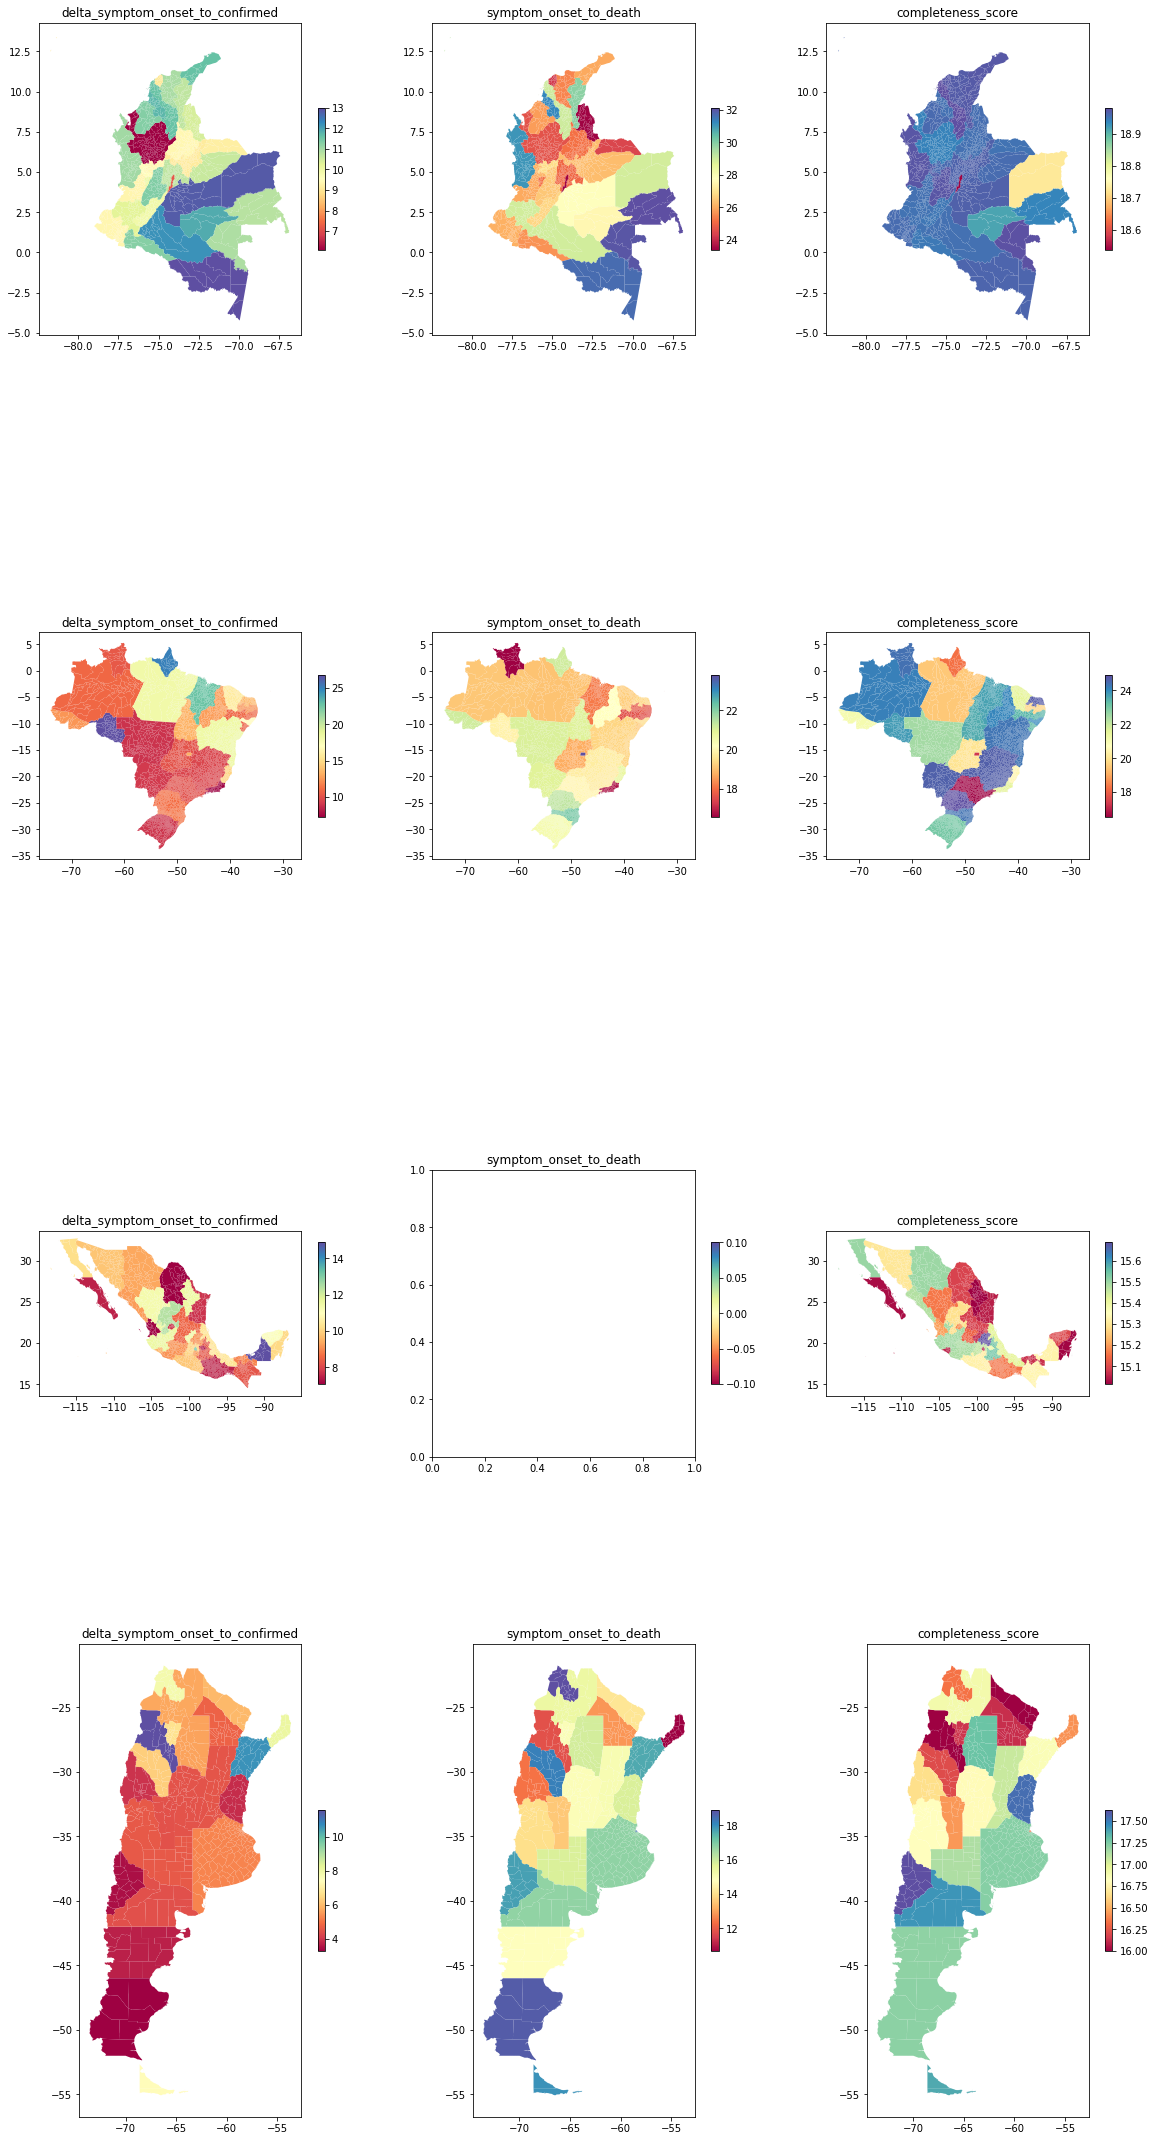

In [126]:
fig,axes = plt.subplots(4,3,figsize=(20,40),sharey=False)

for k,country in enumerate(target_countries):
    country_shapefile_with_delays = country_shapefiles_with_delays_dict[country]
    
    country_shapefile_with_delays.plot(column='delta_symptom_onset_to_confirmed',cmap='Spectral',ax=axes[k,0],legend=True,legend_kwds={'shrink': 0.3})
    axes[k,0].set_title('delta_symptom_onset_to_confirmed')
    country_shapefile_with_delays.plot(column='delta_symptom_onset_to_death',cmap='Spectral',ax=axes[k,1], legend=True,legend_kwds={'shrink': 0.3})
    axes[k,1].set_title('symptom_onset_to_death')
    country_shapefile_with_delays.plot(column='completeness_score',cmap='Spectral',ax=axes[k,2],legend=True,legend_kwds={'shrink': 0.3})
    axes[k,2].set_title('completeness_score')
    
